# Feature selection with L1 Regularization

* Consider a supervised learning setting where you have data $\mathcal{D} = \{(X, Y)\}$, where $X \in \mathbb{R}^{NXD}$. $N$  - num of datapoints and $D$ - num of features. Many of the features may be irrelevant for the task at hand.
* Typically when there are more features than samples, ie. $D >> N$, a simple linear regression model is prone to overfit.
* As we have seen before, regularization is one of the tools in our toolbox to combat overfitting. Here we will see how they do that and how $L1$ regularization can be used for feature selection.

## Tasks

1.  Load the data "cancer_reg.csv" data from [here](https://data.world/nrippner/ols-regression-challenge). A slightly modified copy will be shared with you on workplace. Target is labeled "TARGET_deathRate".
2. Preprocess your data particularly making sure there are no nan values.
3. Split the data into 20\% train and 80\% test sets.
4. Define your linear regression model with and without regularization ($L1$ and $L2$)
5. Train and test your linear regression models (without regularization) till it overfits the data. Plot the learning curves for training and testing (You may ignore loss values for the first 10 epochs)
6. Train and test again with regularization and visually inspect the effects.
7. Plot the weights for each model (using matplotlib stem plot). Do you see any difference between them?
8. In the case of the $L1$ regularization, set a small threshold and remove all features of the data corresponding to the weights with values below this threshold.
9. Train a new model with remaining features (with or without regularization)


In [ ]:
import numpy as np
import pandas as pd

Load the data "cancer_reg.csv" data from here. A slightly modified copy will be shared with you on workplace. Target is labeled "TARGET_deathRate".

In [ ]:
class Dataset:
  def __init__(self, path, test_size=0.8):
    self.test_size = test_size
    self.initialize(path)
    
  def initialize(self, path):
    data = pd.read_csv(path)
    for col in data.columns:
      if data[col].isna().sum()!=0:
        data[col][data[col].isna()] = data[col].mean()
        
    data = data.drop("Unnamed: 0", axis=1)
    target = data["TARGET_deathRate"].values
    inputs = data.drop("TARGET_deathRate", axis=1).values
    inputs = inputs/inputs.max(axis=0)

    self.target = target
    self.inputs = inputs

    indices = np.arange(len(self.target))
    np.random.shuffle(indices)
    test_num_points = int(self.test_size * len(indices))
    test_indices = indices[:test_num_points]
    train_indices = indices[test_num_points:]

    self.train_inputs = self.inputs[train_indices]
    self.test_inputs = self.inputs[test_indices]
    self.train_targets = self.target[train_indices]
    self.test_targets = self.target[test_indices]
  


    

In [ ]:
dataset = Dataset("cancer-mortality-rate.csv")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


In [ ]:
import matplotlib.pyplot as plt

In [ ]:
print("train inputs shape: ",dataset.train_inputs.shape)
print("test inputs shape: ",dataset.test_inputs.shape)

train inputs shape:  (610, 279)
test inputs shape:  (2437, 279)


In [ ]:
class LinearRegressionModel:
  def __init__(self, dataset, l1 = 0.9, l2 = 0.01, lr = 0.001, epochs=10000):
    self.dataset = dataset
    self.l1 = l1
    self.l2 = l2
    self.learning_rate = lr
    self.epochs = epochs
    self.theta = np.random.randn(dataset.train_inputs.shape[1]+1)
  def add_one(self, x):
    ones = np.ones((len(x), 1))
    x = np.concatenate([x,  ones], axis=1)
    return x

  def inference(self, x):
    return x @ self.theta
  def compute_mse_loss(self, y_true, y_pred):
    return ((y_true - y_pred)**2).mean()
  def plot(self, train_losses, test_losses):
    plt.figure()
    plt.title("losses")
    plt.plot(train_losses[10:], label="train-loss")
    plt.plot(test_losses[10:], label="test-loss")
    plt.legend()
    plt.figure()
    plt.title("Theta values")
    plt.stem(self.theta)
    plt.show()
  def drop_features(self, threshold):
    important_features = self.theta > threshold
    print("Droping:{} features".format((self.theta <= threshold).sum()))

    self.dataset.train_inputs = self.dataset.train_inputs[:, important_features[:-1]]

    self.dataset.test_inputs = self.dataset.test_inputs[:, important_features[:-1]]
    self.theta = np.random.randn(self.dataset.train_inputs.shape[1]+1)
  def train(self):
    train_losses = []
    test_losses = []
    for epoch in range(self.epochs):
      indices = np.arange(len(self.dataset.train_inputs))
      np.random.shuffle(indices)
      self.dataset.train_inputs = self.dataset.train_inputs[indices]
      self.dataset.train_targets = self.dataset.train_targets[indices]
      batch_size = 32
      if (len(self.dataset.train_inputs) % batch_size ) == 0:
        number_of_batches = len(self.dataset.train_inputs)//batch_size
      else:
        number_of_batches = len(self.dataset.train_inputs)//batch_size + 1
      epoch_losses = []
      for batch_number in range(number_of_batches):
        x = self.dataset.train_inputs[batch_number * batch_size: (batch_number + 1) * batch_size]
        y = self.dataset.train_targets[batch_number * batch_size: (batch_number + 1) * batch_size]
        x = self.add_one(x)
      
        y_pred = self.inference(x)
        gradient = x.T @ (self.inference(x) - y)
        if self.l1 != 0.0:
          l1_norm_grad =((self.theta > 0).astype(float) * 2 - 1) * self.l1
        else:
          l1_norm_grad = 0
        
        if self.l2 != 0.0:
          l2_norm_grad = self.theta * self.l2
        else:
          l2_norm_grad = 0
        gradient = gradient + l1_norm_grad + l2_norm_grad
        
        self.theta -= gradient * self.learning_rate

        loss = self.compute_mse_loss(y_pred, y)
        epoch_losses.append(loss)

      train_losses.append(np.mean(epoch_losses))
      
      test_inputs = self.dataset.test_inputs
      test_inputs = self.add_one(test_inputs)
      y_pred_test = self.inference(test_inputs)
      test_loss = self.compute_mse_loss(self.dataset.test_targets, y_pred_test)
      test_losses.append(test_loss)
      if epoch % 1000==0:
        print("Epoch: {} train - loss: {:.4f} test-loss: {:.4f}".format(epoch, np.mean(epoch_losses), test_loss))
    self.plot(train_losses, test_losses)





In [ ]:
model = LinearRegressionModel(dataset, l2=0.0, l1=0.0, epochs=10000)

Epoch: 0 train - loss: 3827.5205 test-loss: 1082.1318
Epoch: 1000 train - loss: 316.4980 test-loss: 440.5230
Epoch: 2000 train - loss: 300.8671 test-loss: 456.6004
Epoch: 3000 train - loss: 294.6559 test-loss: 483.9424
Epoch: 4000 train - loss: 304.1573 test-loss: 482.4124
Epoch: 5000 train - loss: 296.5707 test-loss: 482.8578
Epoch: 6000 train - loss: 314.1089 test-loss: 485.7266
Epoch: 7000 train - loss: 337.2459 test-loss: 487.6583
Epoch: 8000 train - loss: 286.5159 test-loss: 491.9580
Epoch: 9000 train - loss: 304.9255 test-loss: 492.4837


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.


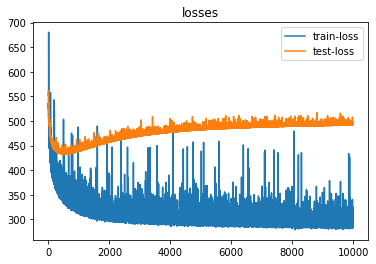

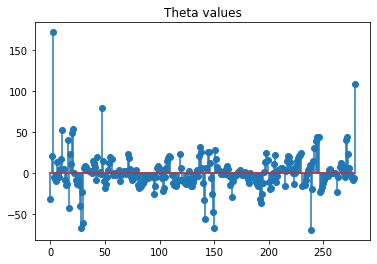

In [ ]:
model.train()

Epoch: 0 train - loss: 5868.9636 test-loss: 870.1231
Epoch: 1000 train - loss: 392.2292 test-loss: 418.3205
Epoch: 2000 train - loss: 398.9186 test-loss: 413.7334
Epoch: 3000 train - loss: 388.4265 test-loss: 413.9593
Epoch: 4000 train - loss: 413.9168 test-loss: 412.6225
Epoch: 5000 train - loss: 406.6113 test-loss: 411.9775
Epoch: 6000 train - loss: 432.3997 test-loss: 412.5627
Epoch: 7000 train - loss: 393.1921 test-loss: 412.7406
Epoch: 8000 train - loss: 387.4281 test-loss: 410.3219
Epoch: 9000 train - loss: 385.2329 test-loss: 410.7806


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.


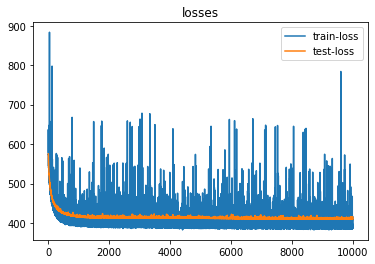

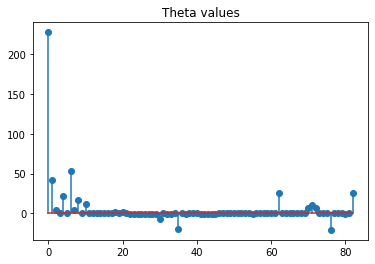

In [ ]:
model = LinearRegressionModel(dataset, l2=0.0, l1=0.9, epochs=10000)
model.train()

In [ ]:
threshold = 0.005
model.drop_features(threshold)
# important_features = model.theta > threshold

Droping:37 features


Epoch: 0 train - loss: 6610.3765 test-loss: 946.8643
Epoch: 1000 train - loss: 506.6249 test-loss: 418.9748
Epoch: 2000 train - loss: 418.5250 test-loss: 411.4339
Epoch: 3000 train - loss: 426.7378 test-loss: 410.8731
Epoch: 4000 train - loss: 404.1111 test-loss: 410.7493
Epoch: 5000 train - loss: 394.3834 test-loss: 410.3831
Epoch: 6000 train - loss: 412.5185 test-loss: 411.5656
Epoch: 7000 train - loss: 425.8812 test-loss: 410.5924
Epoch: 8000 train - loss: 397.2861 test-loss: 410.5629
Epoch: 9000 train - loss: 395.3320 test-loss: 412.6695


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.


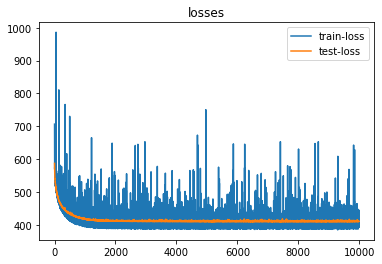

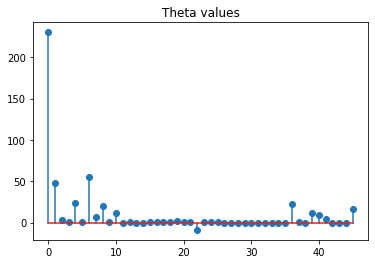

In [ ]:
model.train()

In [ ]:
model.theta.shape

In [ ]:

model.dataset.train_inputs.shape